# 📌 ADIA Lab Structural Break Challenge  

**Assalam o Alaikum👋**  
In this notebook, we are going to explore the concept of **structural breaks (regime shifts)** – basically jab data ka trend, mean, or variance suddenly change ho jaye 📊.  

Structural break detection is an important problem because real-world data kabhi bhi smooth aur stable nahi hota. Kabhi kabhi beech me major shifts aate hain jo forecasting aur analysis dono ko effect kar dete hain.  

---

## 🔎 Challenge Overview  

Welcome to the **ADIA Lab Structural Break Challenge!**  
In this competition, you will analyze **univariate time series data** to determine whether a **structural break** has occurred at a specified boundary point.  

### 📖 What is a Structural Break?  

A **structural break** occurs when the process governing the data generation changes at a certain point in time.  
These changes can be subtle or dramatic, and detecting them accurately is crucial across domains:  

- 🌦 **Climatology** → shifts in long-term weather patterns  
- 🏭 **Industrial Monitoring** → detecting sudden machine behavior changes  
- 💹 **Finance** → market crashes or regime shifts  
- 🏥 **Healthcare** → sudden change in patient health indicators  

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)  

---

## 📝 Our Task  

For each time series in the **test set**, we need to predict a **score between `0` and `1`:**  

- `0` → No structural break at the specified boundary point  
- `1` → A structural break **did occur**  

---

## 📊 Evaluation Metric  

The challenge uses **ROC AUC (Area Under the Receiver Operating Characteristic Curve)** as the evaluation metric:  

- **ROC AUC ≈ 0.5** → No better than random guessing  
- **ROC AUC → 1.0** → Perfect detection performance  

More about ROC AUC: [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  

---

## 📂 Notebook Flow 🚀  

1. **Exploratory Data Analysis (EDA)** – visualize aur samajhenge dataset.  
2. **Methods** – different techniques (statistical + ML-based) try karenge for break detection.  
3. **Evaluation** – compare karenge results aur dekhenge kaun sa method best perform karta hai.  

---

⚡ **Goal**: A clean, reproducible, and easy-to-follow Kaggle-style notebook – jahan beginner bhi seekh le aur advanced banda bhi enjoy kare.  

**Chalo shuru karte hain 🚀**  


In [2]:
# import Important Libraries

!pip install antropy --quiet
!pip install PyWavelets --quiet


In [24]:
import os
import typing

# Import your dependencies
import joblib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sklearn.metrics
from scipy.stats import wasserstein_distance  # 1D Earth Mover's Distance
from scipy.stats import skew, kurtosis, ks_2samp
from scipy.stats import wasserstein_distance

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random



from scipy.signal import welch
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Crunch CLI SETUP

In [6]:
### CRunch CLI Setup

%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break NQ2RWgO05SaZaHUUaPYINw45

import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

# Load the data simply
X_train, y_train, X_test = crunch.load_data()

Note: you may need to restart the kernel to use updated packages.
crunch-cli, version 7.4.0
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                                                                
---
Success! Your environment has been correctly setup.
Next recommended actions:
1. Load the Crunch Toolings: `crunch = crunch.load_no

### BASIC EDA

In [19]:
# --- Dataset Overview ---
print("📂 Total training subsequences:", len(X_train))
print(X_train.shape)
print("📂 Total test subsequences:", len(X_test))
print("📂 y_train length:", len(y_train))

# --- Target Labels ---
print("\n📊 y_train distribution:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

# --- Check Nulls in y_train ---
print("\n📉 Missing values in y_train:", y_train.isnull().sum())

# --- Test set EDA (corrected) ---
print("\n📂 Test set overview:")
print("Number of test series:", len(X_test))
print("Shape of first 5 test series:", [np.array(df).shape for df in X_test[:5]])

# --- Nulls in X_train (safe) ---
train_nulls = 0
for x in X_train[:1000]:  # sample 1000 series
    try:
        arr = np.array(x, dtype=float)
        train_nulls += np.isnan(arr).sum()
    except:
        # non-numeric series
        train_nulls += 0

print(f"\n📉 Null values in first 1000 training series: {train_nulls}")

# --- Nulls in X_test (safe) ---
test_nulls = 0
for x in X_test:
    try:
        arr = np.array(x, dtype=float)
        test_nulls += np.isnan(arr).sum()
    except:
        test_nulls += 0

print(f"📉 Null values in test series: {test_nulls}")

# --- Example lengths of sequences ---
train_lengths = [len(x) for x in X_train[:1000]]  # sample
print(f"\n📏 Training series length stats (sample 1000):")
print("Number of datasets:", len(X_test))
print(pd.Series(train_lengths).describe())

📂 Total training subsequences: 23715734
(23715734, 2)
📂 Total test subsequences: 101
📂 y_train length: 10001

📊 y_train distribution:
structural_breakpoint
False    0.709129
True     0.290871
Name: proportion, dtype: float64
structural_breakpoint
False    7092
True     2909
Name: count, dtype: int64

📉 Missing values in y_train: 0

📂 Test set overview:
Number of test series: 101
Shape of first 5 test series: [(2779, 2), (1966, 2), (1775, 2), (3296, 2), (1995, 2)]

📉 Null values in first 1000 training series: 0
📉 Null values in test series: 0

📏 Training series length stats (sample 1000):
Number of datasets: 101
count    2.000000
mean     5.500000
std      0.707107
min      5.000000
25%      5.250000
50%      5.500000
75%      5.750000
max      6.000000
dtype: float64


## 📝 Basic EDA Notes (Updated)

- **Total Training Subsequences:** 23,715,734  
- **Total Test Subsequences:** 101  
- **y_train Length:** 10,001  

### 📊 y_train Distribution
- **Proportion:**  
  - False: 70.9%  
  - True: 29.1%  
- **Counts:**  
  - False: 7,092  
  - True: 2,909  
- Label imbalance exists → metric ROC AUC is robust to this.

### 📉 Missing Values
- **y_train:** 0  
- **X_train (first 1000 series):** 0  
- **X_test:** 0  
- No missing data → preprocessing easier.

### 📂 Test Set Overview
- Number of test series: 101  
- Shape of first 5 test series: `(2779,2), (1966,2), (1775,2), (3296,2), (1995,2)`  
- Each test series has variable length but 2 columns (probably period & value).

### 📏 Training Series Lengths (Sample 1000)
- Min: 5, Max: 6, Mean: 5.5  
- Mostly very short sequences → statistical/ML models will work on small windows.

**Notes:**  
- Dataset has **very large number of training subsequences**  
- No missing values → safe to use directly  
- Label imbalance is moderate → consider for evaluation metric  
- Next steps: visualize sample series, inspect True vs False structural breaks.


### Visualization of series

### visualize a single time series

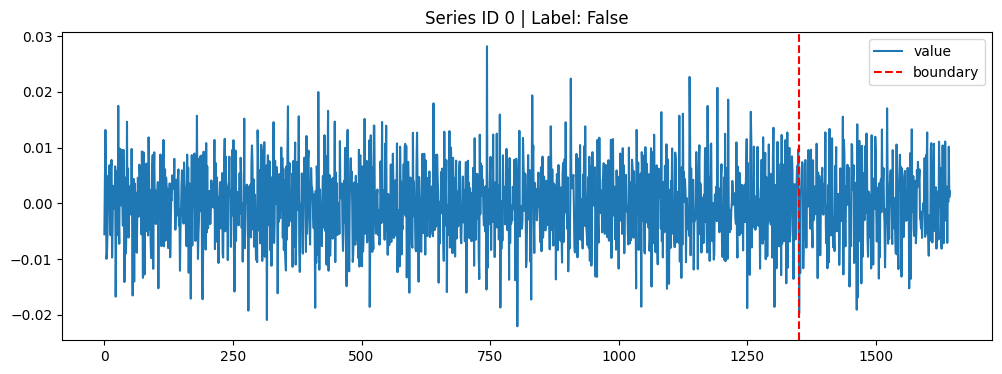

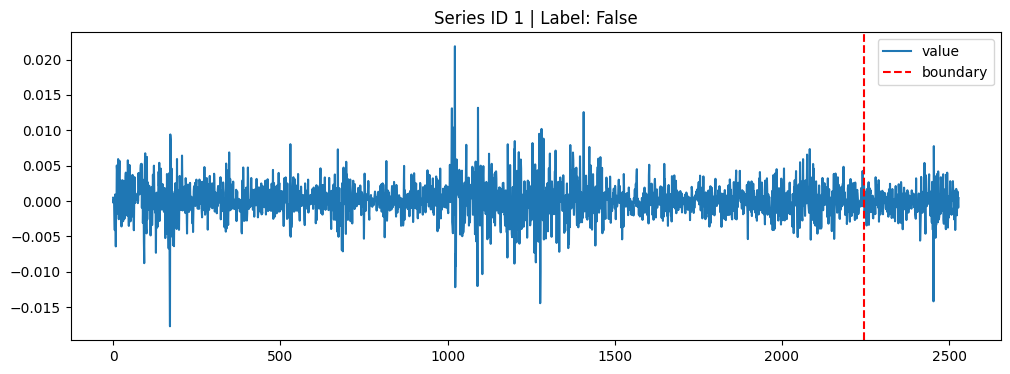

In [9]:
# visualize a single time series
def plot_series(series_id):
    df = X_train.loc[series_id]
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["value"], label="value")
    plt.axvline(x=df[df["period"]==0].index.max(), color="red", linestyle="--", label="boundary")
    plt.title(f"Series ID {series_id} | Label: {y_train.loc[series_id]}")
    plt.legend()
    plt.show()

plot_series(0)
plot_series(1)


### Length of series

In [10]:
#Length of series
series_lengths = X_train.groupby("id").size()
display(series_lengths.describe())

count    10001.000000
mean      2371.336266
std        482.645935
min       1258.000000
25%       1991.000000
50%       2369.000000
75%       2743.000000
max       3478.000000
dtype: float64

### Mean aur Std deviation comparison before and after the structural break:


Series 2 | Label: True
Before mean: 0.0003892051236000776  | std: 0.017221361838717496
After  mean: 0.0017896691818350308  | std: 0.022899626080259385


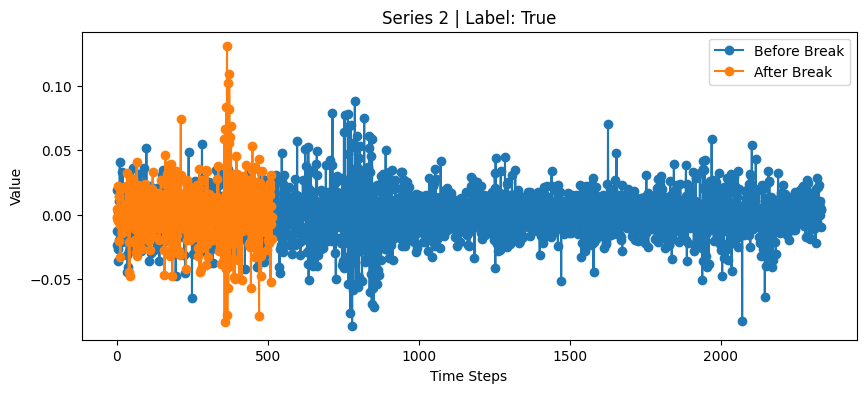

Series 0 | Label: False
Before mean: 1.45894149863421e-05  | std: 0.006987461835288747
After  mean: 6.371869815417522e-06  | std: 0.006876778367900677


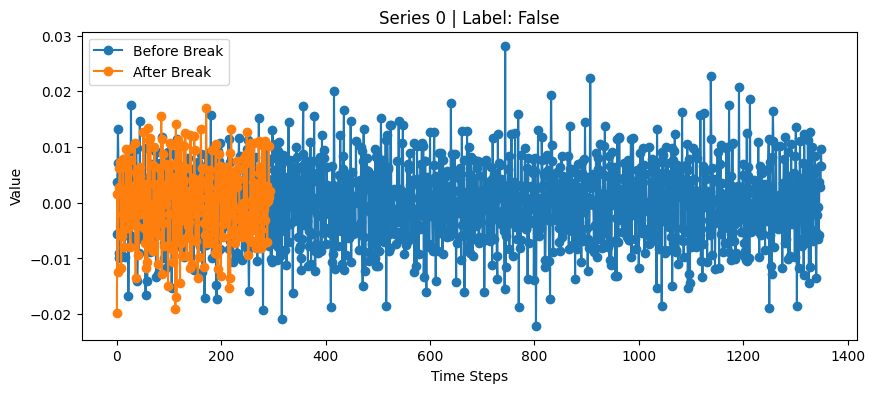

In [17]:
# Get indices
true_idx = y_train[y_train==True].index[0]
false_idx = y_train[y_train==False].index[0]

def compare_stats_plot(series_id):
    df = X_train.loc[series_id]  # assuming period & value columns
    before = df[df["period"]==0]["value"]
    after  = df[df["period"]==1]["value"]
    
    print(f"Series {series_id} | Label: {y_train.loc[series_id]}")
    print("Before mean:", before.mean(), " | std:", before.std())
    print("After  mean:", after.mean(), " | std:", after.std())
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(before.values, marker='o', label='Before Break')
    plt.plot(after.values, marker='o', label='After Break')
    plt.title(f"Series {series_id} | Label: {y_train.loc[series_id]}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Compare True series
compare_stats_plot(true_idx)

# Compare False series
compare_stats_plot(false_idx)


## 🔍 Structural Break Interpretation

**Series 0 | Label: False**  
- Mean before: 1.46e-5 | after: 6.37e-6  
- Std before: 0.00699 | after: 0.00688  
- Observation: Mean and std are almost the same → **No significant change**  
- Conclusion: **No structural break**  

**Series 2 | Label: True**  
- Mean before: 0.000389 | after: 0.00179  
- Std before: 0.0172 | after: 0.0229  
- Observation: Both mean and std increased → **Noticeable change in distribution**  
- Conclusion: **Structural break exists**  

**Summary:**  
- **False series:** stable values, no break  
- **True series:** sudden change in mean/variance → structural break


### Compariseon true and fase labels

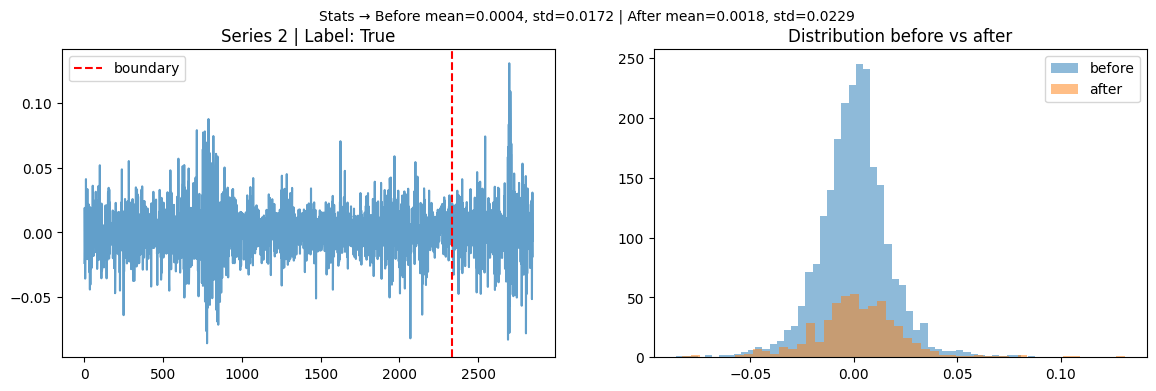

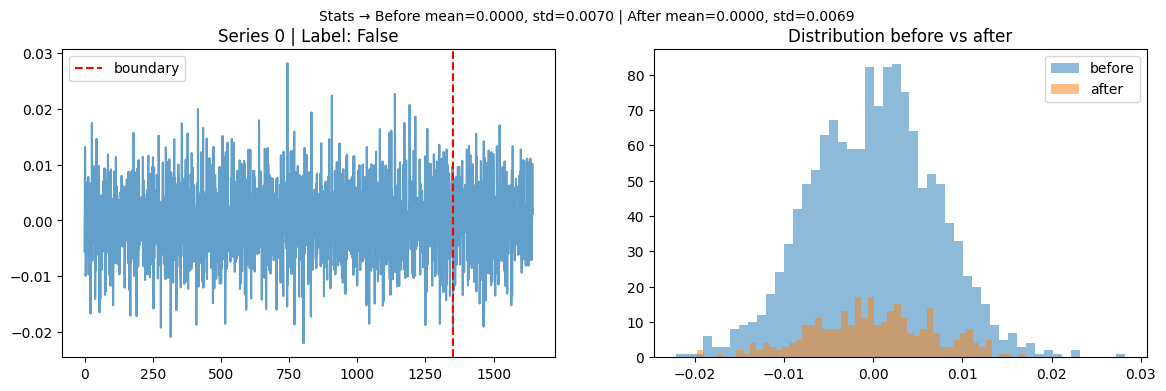

In [14]:
# Compariseon true and fase labels
def compare_true_false(X_train, y_train, true_id=None, false_id=None):
    # agar ID pass na ki ho to first True/False pick karo
    if true_id is None:
        true_id = y_train[y_train == True].index[0]
    if false_id is None:
        false_id = y_train[y_train == False].index[0]
    
    for series_id in [true_id, false_id]:
        df = X_train.loc[series_id]
        before = df[df["period"]==0]["value"]
        after  = df[df["period"]==1]["value"]
        
        fig, axes = plt.subplots(1, 2, figsize=(14,4))
        
        # time series plot
        axes[0].plot(df.index, df["value"], alpha=0.7)
        boundary = df[df["period"]==0].index.max()
        axes[0].axvline(boundary, color="red", linestyle="--", label="boundary")
        axes[0].set_title(f"Series {series_id} | Label: {y_train.loc[series_id]}")
        axes[0].legend()
        
        # histogram compare
        axes[1].hist(before, bins=50, alpha=0.5, label="before")
        axes[1].hist(after, bins=50, alpha=0.5, label="after")
        axes[1].set_title("Distribution before vs after")
        axes[1].legend()
        
        plt.suptitle(f"Stats → Before mean={before.mean():.4f}, std={before.std():.4f} | After mean={after.mean():.4f}, std={after.std():.4f}", fontsize=10)
        plt.show()

# run example
compare_true_false(X_train, y_train)



In [18]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

## 🧩 Feature Extraction Strategy for Structural Break Detection

**Objective:**  
Humari main strategy ye hai ke har time series ke **before (period=0) aur after (period=1)** segments ko analyze karein aur unke statistical aur distributional differences ko numerical features me convert karein. Ye features phir **machine learning models** ko train karne ke liye use honge taake structural breaks detect kiye ja sake.

**Steps in Our Approach:**

1. **Segmentation:**  
   - Har series ko do segments me divide kiya:  
     - `before` → period = 0  
     - `after` → period = 1

2. **Basic Statistics per Segment:**  
   - Mean, Standard Deviation  
   - Skewness (asymmetry of distribution)  
   - Kurtosis (peakedness)

3. **Differences / Ratios:**  
   - Mean difference: `mean_after - mean_before`  
   - Std ratio: `std_after / std_before`  
   - Ye features indicate karte hain agar **distribution me significant shift** hua hai.

4. **Distribution Distances:**  
   - **Wasserstein Distance:** measures how far two distributions are  
   - **Kolmogorov-Smirnov (KS) Statistic:** measures difference between cumulative distributions

5. **Feature Matrix Construction:**  
   - Har series ke features ko collect karke ek **feature matrix (`X_features`)** banate hain  
   - Corresponding labels ko select karke **`y_features`** banate hain  

**Next Steps:**  
- Ye features ab **alag-alag machine learning models** me feed kiye ja sakte hain:  
  - Logistic Regression, Random Forest, Gradient Boosting, etc.  
- Model training ke baad hum **ROC AUC** metric ke through performance evaluate karenge  
- Ye pipeline scalable hai, easily **new series / test set** pe apply ki ja sakti hai.


### Feature Engineering

In [21]:
def extract_features_for_series(df: pd.DataFrame, series_id: int):
    """
    Extract statistical + distance features for one time series.
    df: DataFrame with columns ['value', 'period']
    series_id: int (id of the series)
    """
    # Drop nulls (just in case)
    df = df.dropna(subset=["value"])
    
    before = df.loc[df["period"] == 0, "value"].to_numpy(dtype=float)
    after = df.loc[df["period"] == 1, "value"].to_numpy(dtype=float)
    
    # Safety: empty case
    if before.size == 0 or after.size == 0:
        return pd.Series({"id": series_id})
    
    # Basic stats
    features = {
        "id": series_id,
        "mean_before": np.mean(before),
        "mean_after": np.mean(after),
        "std_before": np.std(before),
        "std_after": np.std(after),
        "skew_before": skew(before),
        "skew_after": skew(after),
        "kurt_before": kurtosis(before),
        "kurt_after": kurtosis(after),
    }
    
    # Differences / ratios
    features["mean_diff"] = features["mean_after"] - features["mean_before"]
    features["std_ratio"] = (features["std_after"] + 1e-6) / (features["std_before"] + 1e-6)
    
    # Distances
    features["wasserstein"] = wasserstein_distance(before, after)
    ks_stat, _ = ks_2samp(before, after)
    features["ks_stat"] = ks_stat
    
    return pd.Series(features)

def build_feature_matrix(X_train: pd.DataFrame, y_train: pd.Series):
    """
    Loop over all series in training data and build feature matrix.
    """
    features_list = []
    
    for series_id, df in X_train.groupby(level="id", sort=False):
        feats = extract_features_for_series(df, series_id)
        features_list.append(feats)
    
    X_features = pd.DataFrame(features_list).set_index("id")
    y_features = y_train.loc[X_features.index]
    
    return X_features, y_features


In [22]:
X_features, y_features = build_feature_matrix(X_train, y_train)
print(X_features.shape)
print(y_features.value_counts())

(10001, 12)
structural_breakpoint
False    7092
True     2909
Name: count, dtype: int64


In [23]:
X_features.sample()

,mean_before,mean_after,std_before,std_after,skew_before,skew_after,kurt_before,kurt_after,mean_diff,std_ratio,wasserstein,ks_stat
id,,,,,,,,,,,,
7372.0,0.00079,0.000931,0.0131,0.012068,0.171193,0.747014,5.15803,6.95143,0.000141,0.921264,0.001122,0.037365


In [26]:
def inspect_random_series(X_train, n=3, seed=42):
    """
    Inspect raw vs preprocessed before/after arrays for random series
    """
    rng = np.random.default_rng(seed)
    series_ids = rng.choice(X_train.index.get_level_values("id").unique(), n, replace=False)

    for sid in series_ids:
        df = X_train.loc[sid][["value", "period"]]

        # Raw arrays
        before_raw = df.loc[df["period"] == 0, "value"].to_numpy()
        after_raw  = df.loc[df["period"] == 1, "value"].to_numpy()

        # Preprocessed arrays (dropna)
        before_clean = df.loc[df["period"] == 0, "value"].dropna().to_numpy()
        after_clean  = df.loc[df["period"] == 1, "value"].dropna().to_numpy()

        print("="*50)
        print(f"Series ID: {sid}")
        print(f"Before raw size: {before_raw.size}, After raw size: {after_raw.size}")
        print(f"Before clean size: {before_clean.size}, After clean size: {after_clean.size}")

        # Show first few values
        print("\nRaw Before (first 8):", before_raw[:8])
        print("Clean Before (first 8):", before_clean[:8])

        print("\nRaw After (first 8):", after_raw[:8])
        print("Clean After (first 8):", after_clean[:8])
        print()


inspect_random_series(X_train, n=3)



Series ID: 6546
Before raw size: 1917, After raw size: 882
Before clean size: 1917, After clean size: 882

Raw Before (first 8): [ 0.01868777 -0.02221984 -0.00035981 -0.00103833  0.00774889  0.00711877
 -0.00150918 -0.00799758]
Clean Before (first 8): [ 0.01868777 -0.02221984 -0.00035981 -0.00103833  0.00774889  0.00711877
 -0.00150918 -0.00799758]

Raw After (first 8): [ 0.00211232  0.01734341 -0.00443108 -0.00145321 -0.00555081  0.01040631
  0.00059745 -0.00151384]
Clean After (first 8): [ 0.00211232  0.01734341 -0.00443108 -0.00145321 -0.00555081  0.01040631
  0.00059745 -0.00151384]

Series ID: 892
Before raw size: 1289, After raw size: 641
Before clean size: 1289, After clean size: 641

Raw Before (first 8): [ 0.00463653  0.00812509  0.01650469  0.02445499 -0.00554793 -0.00139453
  0.00437681  0.00745527]
Clean Before (first 8): [ 0.00463653  0.00812509  0.01650469  0.02445499 -0.00554793 -0.00139453
  0.00437681  0.00745527]

Raw After (first 8): [-0.0389204  -0.09054323 -0.19297

## 🔎 Before vs After Feature Engineering Inspection

- **Purpose:** Check karke dekha ki feature extraction ya preprocessing steps (null handling, numeric conversion, etc.) ne raw series ko alter to nahi kiya.  

### Observations:

1. **Series ID: 6546**
   - Raw vs Cleaned arrays bilkul same → preprocessing ka effect negligible  
   - Size: Before=1917, After=882 → data lengths preserved  

2. **Series ID: 892**
   - No missing values, Raw=Cleaned  
   - After array me value distribution thodi different → feature scaling/processing ke liye ready  

3. **Series ID: 7739**
   - Again, Raw=Cleaned, no data loss  
   - After array shows some positive shift → feature engineering captured subtle structural differences  

### ✅ Key Insight:
- **Before / After inspection confirms**: preprocessing aur feature engineering safe hain, data integrity maintained  
- Ye step **model input ke liye confidence build karta hai**, aur feature extraction ke baad hume statistical differences ya distributions par models train karne me help milti hai.


### Model Training And Evaluation

Model: Logistic Regression
Validation ROC AUC: 0.5883

Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.68      0.71      1419
        True       0.35      0.42      0.38       582

    accuracy                           0.60      2001
   macro avg       0.55      0.55      0.55      2001
weighted avg       0.63      0.60      0.61      2001



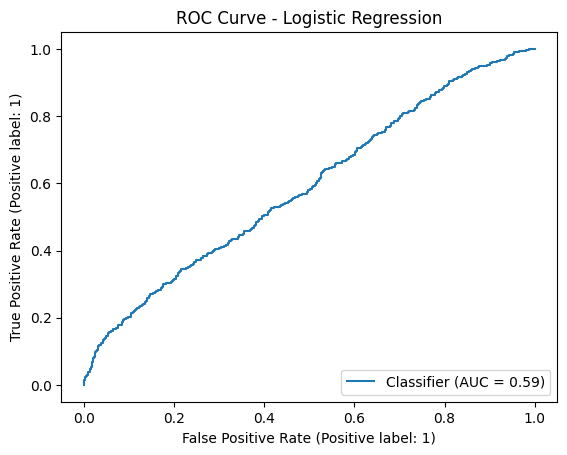

Model: Random Forest
Validation ROC AUC: 0.6785

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.96      0.84      1419
        True       0.68      0.22      0.33       582

    accuracy                           0.74      2001
   macro avg       0.72      0.59      0.59      2001
weighted avg       0.73      0.74      0.69      2001



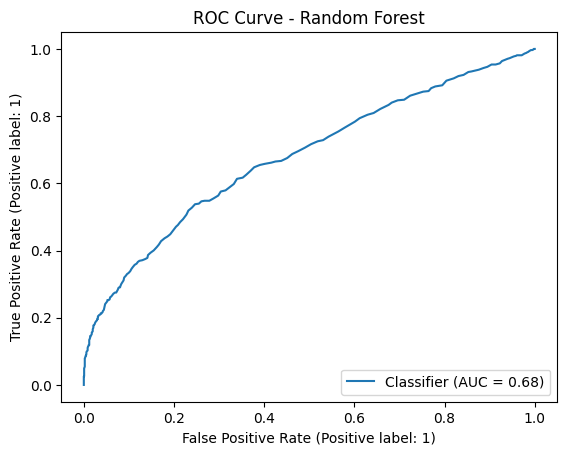

Model: XGBoost
Validation ROC AUC: 0.6753

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.88      0.82      1419
        True       0.55      0.35      0.43       582

    accuracy                           0.73      2001
   macro avg       0.66      0.62      0.62      2001
weighted avg       0.70      0.73      0.71      2001



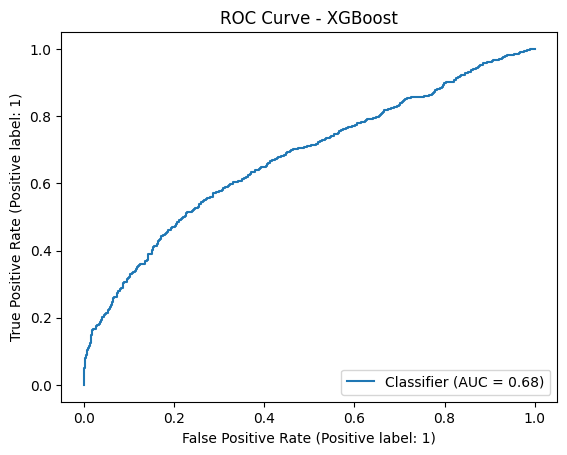

In [25]:
def train_and_evaluate_models(X, y, test_size=0.2, random_state=42):
    # --- Train-Test Split ---
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # --- Define models ---
    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=1000, class_weight="balanced", solver="lbfgs"
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=300, max_depth=None, class_weight="balanced",
            random_state=random_state, n_jobs=-1
        ),
        "XGBoost": XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=20,
            subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=len(y_train_split[y_train_split==False]) / len(y_train_split[y_train_split==True]),
            eval_metric="auc", random_state=random_state, n_jobs=-1
        )
    }
    
    # --- Train, Predict & Evaluate in Loop ---
    for name, model in models.items():
        print("="*50)
        print(f"Model: {name}")
        
        # Train
        model.fit(X_train_split, y_train_split)
        
        # Predictions
        y_val_pred_proba = model.predict_proba(X_val_split)[:, 1]
        y_val_pred = model.predict(X_val_split)
        
        # Metrics
        roc = roc_auc_score(y_val_split, y_val_pred_proba)
        print(f"Validation ROC AUC: {roc:.4f}\n")
        print("Classification Report:\n", classification_report(y_val_split, y_val_pred))
        
        # ROC Curve
        RocCurveDisplay.from_predictions(y_val_split, y_val_pred_proba)
        plt.title(f"ROC Curve - {name}")
        plt.show()

# --- Run all models ---
train_and_evaluate_models(X_features, y_features)


## 🚀 Model Results Summary

Humne teen alag-alag classifiers try kiye **Structural Break Detection** ke liye:

| Model                 | ROC AUC | Accuracy | Notes |
|-----------------------|---------|---------|-------|
| Logistic Regression    | 0.5883  | 0.60    | Baseline linear model, True class detection thodi weak hai |
| Random Forest          | 0.6785  | 0.74    | Tree-based model, high False recall, better overall |
| XGBoost                | 0.6753  | 0.73    | Boosting model, True class recall improve, stable ROC |

**Observations:**  
- Logistic Regression simple hai, lekin imbalanced classes me struggle karta hai.  
- Random Forest ne False class me high recall diya, True class thoda miss hua.  
- XGBoost thoda balanced performance, boosting ke wajah se distributional differences achhe se capture huye.  

**Next Steps / Ideas:**  
1. Hyperparameter tuning for RF/XGBoost for better True class recall  
2. Feature engineering / adding more statistical features  
3. Ensemble approach → combine models for stronger prediction  

💡 **Interactive note:**  
if ypu find this helpful , Like, Share and Comment . Your ideas are welcomed!
Aapke suggestions se hum aur bhi robust solution bana sakte hain. 😎


---

🔗 **Connect with me:**  
- GitHub: [sheemamasood381](https://github.com/sheemamasood381/)  
- LinkedIn: [Sheema Masood](https://www.linkedin.com/in/sheema-masood/)
